In [2]:
import pandas as pd
import tarfile
from google.colab import drive
import re
import string
import numpy as np

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud

# NLP utils
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
nltk.download('wordnet') 
from nltk.stem import WordNetLemmatizer

# Gensim (Word2Vec, Doc2Vec)
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec

# SKlearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, classification_report, silhouette_score, calinski_harabasz_score
from sklearn.datasets import load_files
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD 
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import TruncatedSVD


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load data

In [3]:
# Mount gdrive
drive.mount('/content/gdrive', force_remount=True)
root_dir = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive


### Load raw-data

In [ ]:
tar = tarfile.open(root_dir+'amazon_review_full_csv.tar.gz', "r:gz")
tar.extractall()
tar.close()

In [ ]:
df = pd.read_csv('/content/amazon_review_full_csv/test.csv', names=['score', 'title', 'review'], )

In [ ]:
df = df.sample(n=300000, random_state=99).reset_index(drop=True)

In [ ]:
# Positive sentiment if score >= 4
df['sentiment'] = df['score'].apply(lambda x: 0 if x<4 else 1)

In [ ]:
df.head()

,score,title,review,sentiment
0,3,A Full Range Of Music and Emotion,"As others have so eloquently detailed already,...",0
1,2,Just one little 'gotcha!',"""Compatible"" may be a stretch in Mac user term...",0
2,4,Great Game,"If you are a WWII Fan and new into games, you ...",1
3,2,"""Magic in the Middle Ages"" is a good source of...",'Magic in the Middle Ages' takes a profound lo...,0
4,5,Perfect mat for what I needed.,Wanted a set of mats that actually protect the...,1


In [ ]:
# Check the distribution of the sentiment
df.groupby('sentiment').size()

sentiment
0    180003
1    119997
dtype: int64

### Data preprocessing

In [ ]:
def remove_urls(text):
    return re.sub(r'https?://\S+|www.\.\S+', '', text)

def remove_emojis(text):
    #Reference: https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def remove_punctuation(text, punctuation=None):
    if punctuation is None:
        punctuation = string.punctuation
    return text.translate(str.maketrans(punctuation, ' '*len(punctuation)))

def remove_stopwords(text, stopwords=None):
    if stopwords is None:
        stopwords = set(stopwords.words('english'))
    return ' '.join([word for word in text.split() if word not in stopwords])

def remove_extra_whitespace(text):
    return " ".join(text.split())

def get_wordnet_pos(text):
    # Map POS tag to first character lemmatize() accepts
    tags = nltk.pos_tag(text)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tags = [tag_dict.get(tag[1][0],  wordnet.NOUN) for tag in tags]
    return tags

def lemmaSentence(text, lemmatizer):
    lemma_text = ''
    tok_text = word_tokenize(text)
    tags = get_wordnet_pos(tok_text)
    for i in range(len(tok_text)):
        lemma_text = lemma_text + ' ' + lemmatizer.lemmatize(tok_text[i], tags[i])
    return lemma_text[1:]

In [ ]:
def preprocess(text):
    
    text = text.lower()
    text = remove_urls(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text, STOPWORDS)
    # Remove words that are digits only
    text = re.sub(r'\b\d+\b', '', text)
    text = remove_extra_whitespace(text)

    #Lemmatization with POS tagging\
    text = lemmaSentence(text, WordNetLemmatizer())

    return text

In [ ]:
STOPWORDS = stopwords.words('english')
STOPWORDS.remove('not')
STOPWORDS.remove('is')
STOPWORDS.remove('but')
# 'not' may be relevant in classifying reviews as positive negative
# E.g., bigram "not good"
STOPWORDS.append('even')
STOPWORDS.append('one')
# some other stopwords found during dataset exploration

In [ ]:
df["preprocessed"] = df['review'].apply(preprocess)

In [ ]:
df.head()

,score,title,review,sentiment,preprocessed
0,3,A Full Range Of Music and Emotion,"As others have so eloquently detailed already,...",0,others eloquently detail already album explore...
1,2,Just one little 'gotcha!',"""Compatible"" may be a stretch in Mac user term...",0,compatible may stretch mac user term certainly...
2,4,Great Game,"If you are a WWII Fan and new into games, you ...",1,wwii fan new game enjoy little bit old but sti...
3,2,"""Magic in the Middle Ages"" is a good source of...",'Magic in the Middle Ages' takes a profound lo...,0,magic middle age take profound look important ...
4,5,Perfect mat for what I needed.,Wanted a set of mats that actually protect the...,1,want set mat actually protect rav fit bill fit...


In [ ]:
df.to_csv('/content/gdrive/MyDrive/preprocessed_df.csv', index=False)

### Load preprocessed data (if already runned the previous code)

In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/preprocessed_df.csv')

In [5]:
df.dropna(axis=0, inplace=True)

In [6]:
df.head()

,score,title,review,sentiment,preprocessed
0,3,A Full Range Of Music and Emotion,"As others have so eloquently detailed already,...",0,others eloquently detail already album explore...
1,2,Just one little 'gotcha!',"""Compatible"" may be a stretch in Mac user term...",0,compatible may stretch mac user term certainly...
2,4,Great Game,"If you are a WWII Fan and new into games, you ...",1,wwii fan new game enjoy little bit old but sti...
3,2,"""Magic in the Middle Ages"" is a good source of...",'Magic in the Middle Ages' takes a profound lo...,0,magic middle age take profound look important ...
4,5,Perfect mat for what I needed.,Wanted a set of mats that actually protect the...,1,want set mat actually protect rav fit bill fit...


## Some visualizations

In [ ]:
def get_wordcloud(text, color='viridis'):
  # Create a WordCloud object
  wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', colormap=color)
  # Generate a word cloud
  return wordcloud.generate(text)

(-0.5, 399.5, 199.5, -0.5)

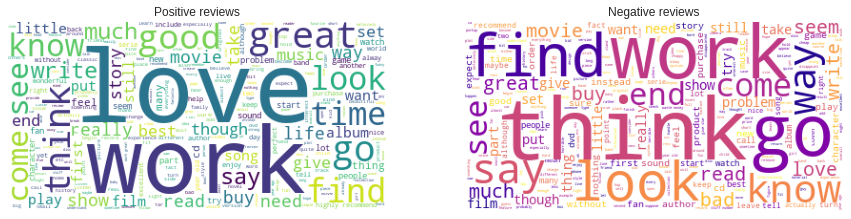

In [ ]:
fig = plt.figure(figsize=(15, 5))

# Wordcloud for positive reviews
ax = fig.add_subplot(1, 2, 1)
plt.title('Positive reviews')
pos_reviews = ' '.join(df['preprocessed'][df['sentiment']==1].values)
# Remove most common words for a cleaner wordcloud
words = ['well', 'make', 'book', 'use']
for word in words:
  pos_reviews = pos_reviews.replace(word, '')
ax.imshow(get_wordcloud(pos_reviews))
ax.axis('off')

# Wordcloud for negative reviews
ax = fig.add_subplot(1, 2, 2)
plt.title('Negative reviews')
neg_reviews = ' '.join(df['preprocessed'][df['sentiment']==0].values)
# Remove most common words for a cleaner wordcloud
words = ['well', 'make', 'book', 'use']
for word in words:
  neg_reviews = neg_reviews.replace(word, '')
ax.imshow(get_wordcloud(neg_reviews, 'plasma'))
ax.axis('off')

# Classification

## Documents representation

In [ ]:
x = df['preprocessed'].values
y = df['sentiment'].values

In [ ]:
# Train and test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### Bag-of-words Tf-Idf

In [ ]:
# Tf-Idf representation
tfidf_vect = TfidfVectorizer(min_df=5, max_features=10000, ngram_range=(1,2), lowercase=False, tokenizer=word_tokenize)
x_train_tfidf = tfidf_vect.fit_transform(x_train)

In [ ]:
x_test_tfidf = tfidf_vect.transform(x_test)

### Word2Vec - Averaged vector

In [ ]:
# Tokenization
x_train_tok = [word_tokenize(sentence) for sentence in x_train]
x_test_tok = [word_tokenize(sentence) for sentence in x_test]

In [ ]:
# Word2Vec model
model_w2v = Word2Vec(min_count=10,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20)

In [ ]:
# Building vocabulary
model_w2v.build_vocab(x_train_tok)

In [ ]:
# Training model
model_w2v.train(x_train_tok, total_examples=model_w2v.corpus_count, epochs=30, report_delay=1)

(126528844, 251142330)

In [ ]:
model_w2v.save("/content/gdrive/MyDrive/w2v.model")

In [ ]:
model_w2v = gensim.models.word2vec.Word2Vec.load("/content/gdrive/MyDrive/w2v.model")

In [ ]:
# W2V model test
model_w2v.wv.most_similar('movie', topn=10)

[('film', 0.8512142300605774),
 ('watch', 0.6268854141235352),
 ('act', 0.5919930338859558),
 ('flick', 0.5776720643043518),
 ('scene', 0.5594290494918823),
 ('actor', 0.5561916828155518),
 ('episode', 0.5458234548568726),
 ('story', 0.5438702702522278),
 ('rent', 0.5296580791473389),
 ('watched', 0.5176247358322144)]

In [ ]:
# Compute mean vector given the w2v vector for every word in a document
def get_mean_vector(model_w2v, words):
    # remove out-of-vocabulary words
    words = [word for word in words if word in model_w2v.wv.vocab]
    if len(words) >= 1:
        return np.mean(model_w2v[words], axis=0)
    else:
        return np.zeros(300)

In [ ]:
# Get the mean vector
x_train_w2v = [get_mean_vector(model_w2v, review) for review in x_train_tok]
x_test_w2v = [get_mean_vector(model_w2v, review) for review in x_test_tok]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [ ]:
# Scaling values between 0 and 1
scaler_w2v = MinMaxScaler(feature_range=(0,1))
x_train_w2v = scaler_w2v.fit_transform(x_train_w2v)
x_test_w2v = scaler_w2v.transform(x_test_w2v)

### Doc2Vec

In [ ]:
# Tag all the documents
tagged_data = [TaggedDocument(doc, tags=[str(i)]) for i, doc in enumerate(x_train_tok)]

In [ ]:
# Building of the Doc2Vec model
model_d2v = gensim.models.doc2vec.Doc2Vec(vector_size=100, window=5, min_count=2, epochs=10)
model_d2v.build_vocab(tagged_data)
model_d2v.train(tagged_data, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)

In [ ]:
model_d2v.save("/content/gdrive/MyDrive/d2v.model")

In [ ]:
model_d2v = gensim.models.doc2vec.Doc2Vec.load("/content/gdrive/MyDrive/d2v.model")

In [ ]:
# Get the vectors for every document
x_train_d2v = model_d2v.docvecs.vectors_docs
x_test_d2v = [model_d2v.infer_vector(doc) for doc in x_test_tok]

In [ ]:
# Scaling values between 0 and 1
scaler_d2v = MinMaxScaler(feature_range=(0,1))
x_train_d2v = scaler_d2v.fit_transform(x_train_d2v)
x_test_d2v = scaler_d2v.transform(x_test_d2v)

## Building the models

### Bag-of-words Tf-Idf

In [ ]:
# Naive bayes
clf_nb_bow = MultinomialNB()
clf_nb_bow.fit(x_train_tfidf, y_train)

MultinomialNB()

In [ ]:
pred = clf_nb_bow.predict(x_test_tfidf)
print(classification_report(y_test, pred, digits=5))

              precision    recall  f1-score   support

           0    0.78799   0.90232   0.84129     54067
           1    0.81197   0.63469   0.71247     35931

    accuracy                        0.79547     89998
   macro avg    0.79998   0.76851   0.77688     89998
weighted avg    0.79756   0.79547   0.78986     89998



In [ ]:
# Support vector machine
clf_svm_bow = LinearSVC(max_iter=1000)
clf_svm_bow.fit(x_train_tfidf, y_train)

LinearSVC()

In [ ]:
pred = clf_svm_bow.predict(x_test_tfidf)
print(classification_report(y_test, pred, digits=5))

              precision    recall  f1-score   support

           0    0.84630   0.86724   0.85664     54067
           1    0.79250   0.76299   0.77747     35931

    accuracy                        0.82562     89998
   macro avg    0.81940   0.81511   0.81705     89998
weighted avg    0.82482   0.82562   0.82503     89998



In [ ]:
# Logistic regression
clf_logr_bow = LogisticRegression(max_iter=1000)
clf_logr_bow.fit(x_train_tfidf, y_train)

LogisticRegression()

In [ ]:
pred = clf_logr_bow.predict(x_test_tfidf)
print(classification_report(y_test, pred, digits=5))

              precision    recall  f1-score   support

           0    0.84292   0.87715   0.85969     54067
           1    0.80311   0.75403   0.77780     35931

    accuracy                        0.82800     89998
   macro avg    0.82301   0.81559   0.81875     89998
weighted avg    0.82702   0.82800   0.82700     89998



### Word2Vec - Averaged vector


In [ ]:
# Naive bayes
clf_nb_w2v = MultinomialNB()
clf_nb_w2v.fit(x_train_w2v, y_train)

MultinomialNB()

In [ ]:
pred = clf_nb_w2v.predict(x_test_w2v)
print(classification_report(y_test, pred, digits=5))

              precision    recall  f1-score   support

           0    0.60393   0.99919   0.75283     54067
           1    0.91927   0.01394   0.02747     35931

    accuracy                        0.60584     89998
   macro avg    0.76160   0.50656   0.39015     89998
weighted avg    0.72982   0.60584   0.46324     89998



In [ ]:
# Support vector machine
clf_svm_w2v = LinearSVC(max_iter=1000)
clf_svm_w2v.fit(x_train_w2v, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinearSVC()

In [ ]:
pred = clf_svm_w2v.predict(x_test_w2v)
print(classification_report(y_test, pred, digits=5))

              precision    recall  f1-score   support

           0    0.79649   0.86437   0.82904     54067
           1    0.76589   0.66767   0.71341     35931

    accuracy                        0.78584     89998
   macro avg    0.78119   0.76602   0.77123     89998
weighted avg    0.78427   0.78584   0.78288     89998



In [ ]:
# Logistic regression
clf_logr_w2v = LogisticRegression(max_iter=1000)
clf_logr_w2v.fit(x_train_w2v, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [ ]:
pred = clf_logr_w2v.predict(x_test_w2v)
print(classification_report(y_test, pred, digits=5))

              precision    recall  f1-score   support

           0    0.79789   0.86145   0.82845     54067
           1    0.76312   0.67165   0.71447     35931

    accuracy                        0.78567     89998
   macro avg    0.78051   0.76655   0.77146     89998
weighted avg    0.78401   0.78567   0.78295     89998



### Doc2Vec

In [ ]:
# Naive bayes
clf_nb_d2v = MultinomialNB()
clf_nb_d2v.fit(x_train_d2v, y_train)

MultinomialNB()

In [ ]:
pred = clf_nb_d2v.predict(x_test_d2v)
print(classification_report(y_test, pred, digits=5))

              precision    recall  f1-score   support

           0    0.60076   1.00000   0.75059     54067
           1    0.00000   0.00000   0.00000     35931

    accuracy                        0.60076     89998
   macro avg    0.30038   0.50000   0.37530     89998
weighted avg    0.36091   0.60076   0.45092     89998



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
# Support vector machine
clf_svm_d2v = LinearSVC(max_iter=1000)
clf_svm_d2v.fit(x_train_d2v, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinearSVC()

In [ ]:
pred = clf_svm_d2v.predict(x_test_d2v)
print(classification_report(y_test, pred, digits=5))

              precision    recall  f1-score   support

           0    0.73238   0.85085   0.78718     54067
           1    0.70337   0.53216   0.60590     35931

    accuracy                        0.72362     89998
   macro avg    0.71787   0.69151   0.69654     89998
weighted avg    0.72080   0.72362   0.71481     89998



In [ ]:
# Logistic regression
clf_logr_d2v = LogisticRegression(max_iter=1000)
clf_logr_d2v.fit(x_train_d2v, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [ ]:
pred = clf_logr_d2v.predict(x_test_d2v)
print(classification_report(y_test, pred, digits=5))

              precision    recall  f1-score   support

           0    0.73562   0.84589   0.78691     54067
           1    0.70057   0.54254   0.61151     35931

    accuracy                        0.72478     89998
   macro avg    0.71809   0.69422   0.69921     89998
weighted avg    0.72163   0.72478   0.71688     89998



## Models comparison

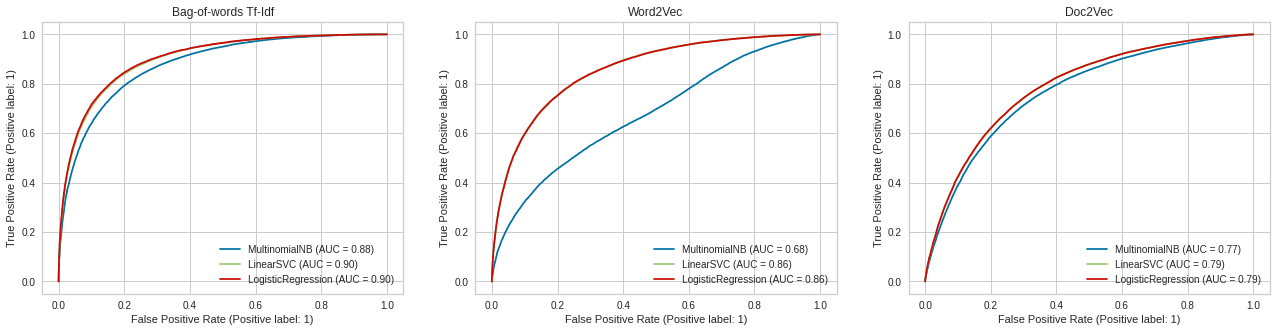

In [ ]:
# Plot the Roc-curve for every classifier
plt.figure(figsize=(22, 5))

# BOW classifiers
classifiers = [clf_nb_bow, clf_svm_bow, clf_logr_bow]
plt.subplot(1, 3, 1)
plt.title('Bag-of-words Tf-Idf')
ax = plt.gca()
for classifier in classifiers:
  RocCurveDisplay.from_estimator(classifier, x_test_tfidf, y_test, ax=ax)

# W2V classifiers
classifiers = [clf_nb_w2v, clf_svm_w2v, clf_logr_w2v]
plt.subplot(1, 3, 2)
plt.title('Word2Vec')
ax = plt.gca()
for classifier in classifiers:
  RocCurveDisplay.from_estimator(classifier, x_test_w2v, y_test, ax=ax)

# D2V classifiers
classifiers = [clf_nb_d2v, clf_svm_d2v, clf_logr_d2v]
plt.subplot(1, 3, 3)
plt.title('Doc2Vec')
ax = plt.gca()
for classifier in classifiers:
  RocCurveDisplay.from_estimator(classifier, x_test_d2v, y_test, ax=ax)

# Clustering

## Documents representation

In [7]:
x = df['preprocessed'].values
y = df['sentiment'].values

In [8]:
# Tf-Idf representation
tfidf_vect = TfidfVectorizer(min_df=5, max_features=10000, ngram_range=(1, 1), lowercase=False, tokenizer=word_tokenize)
x_tfidf = tfidf_vect.fit_transform(x)

In [9]:
# Dimensionality reduction
svd = TruncatedSVD(n_components=100)
x_svd = svd.fit_transform(x_tfidf) 

## Building clusters

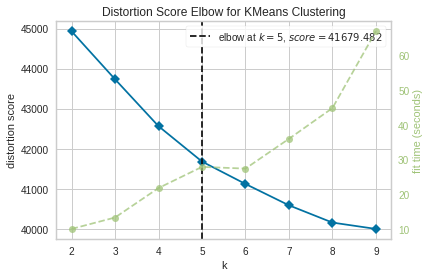

In [10]:
# Find the best number of clusters
model_km = KMeans(random_state=1)
visualizer = KElbowVisualizer(model_km, k=(2, 10))

visualizer.fit(x_svd)
visualizer.show()

In [20]:
# Compute KMeans clustering
kmeans = KMeans(n_clusters=visualizer.elbow_value_, random_state=1)
clusters = kmeans.fit_predict(x_svd)

In [21]:
df['cluster'] = clusters

In [22]:
df.head()

,score,title,review,sentiment,preprocessed,cluster
0,3,A Full Range Of Music and Emotion,"As others have so eloquently detailed already,...",0,others eloquently detail already album explore...,1
1,2,Just one little 'gotcha!',"""Compatible"" may be a stretch in Mac user term...",0,compatible may stretch mac user term certainly...,4
2,4,Great Game,"If you are a WWII Fan and new into games, you ...",1,wwii fan new game enjoy little bit old but sti...,2
3,2,"""Magic in the Middle Ages"" is a good source of...",'Magic in the Middle Ages' takes a profound lo...,0,magic middle age take profound look important ...,4
4,5,Perfect mat for what I needed.,Wanted a set of mats that actually protect the...,1,want set mat actually protect rav fit bill fit...,4


## Performance evaluation

In [23]:
# Silhouette score
silhouette_score(x_svd, clusters, metric='euclidean')

0.06174317008155839

In [24]:
# Calinski-Harabasz score
calinski_harabasz_score(x_svd, clusters)

9320.472428562953

## Clusters visualizations

In [ ]:
# TruncatedSVD for 2D visualization
svd_2d = TruncatedSVD(n_components=2)
x_2d = svd.fit_transform(x_tfidf) 
scatter_x_2d = x_2d[:, 0]
scatter_y_2d = x_2d[:, 1]

In [ ]:
# TruncatedSVD for 3D visualization
svd_3d = TruncatedSVD(n_components=3)
x_3d = svd.fit_transform(x_tfidf) 
scatter_x_3d = x_3d[:, 0]
scatter_y_3d = x_3d[:, 1]
scatter_z_3d = x_3d[:, 2]

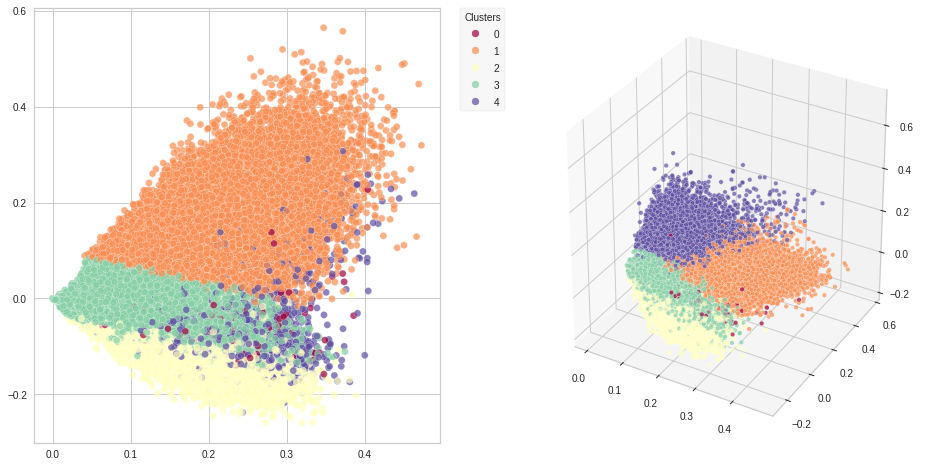

In [ ]:
fig = plt.figure(figsize=(16, 8))

# 2D scatter
ax = fig.add_subplot(1, 2, 1)
scatter1 = ax.scatter(x=scatter_x_2d, y=scatter_y_2d, c=df['cluster'], cmap='Spectral', edgecolor='white', alpha=0.7)

# Legend
legend = plt.legend(*scatter1.legend_elements(), bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0, title='Clusters', frameon=1, facecolor='whitesmoke')

# 3D scatter
ax = fig.add_subplot(1, 2, 2, projection='3d')
scatter2 = ax.scatter(xs=scatter_x_3d, ys=scatter_y_3d, zs=scatter_z_3d, c=df['cluster'], cmap='Spectral', edgecolor='white', alpha=0.7)

plt.show()

In [ ]:
# Show positive and negative percentage for every cluster
pos_neg = pd.DataFrame.join(
    df[['sentiment', 'cluster']][df['sentiment']==0].groupby(['cluster']).count().rename(columns={'sentiment':'neg'}), 
    df[['sentiment', 'cluster']][df['sentiment']==1].groupby(['cluster']).count().rename(columns={'sentiment':'pos'})
    )

pos_neg['pos_perc'] = pos_neg['pos']/(pos_neg['pos']+pos_neg['neg'])
pos_neg['neg_perc'] = pos_neg['neg']/(pos_neg['pos']+pos_neg['neg'])

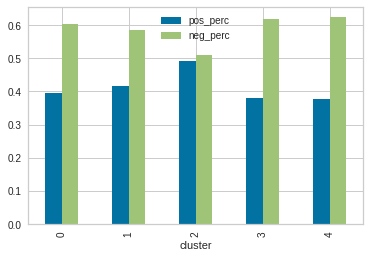

In [ ]:
ax = pos_neg.drop(['pos', 'neg'], axis=1).plot.bar()

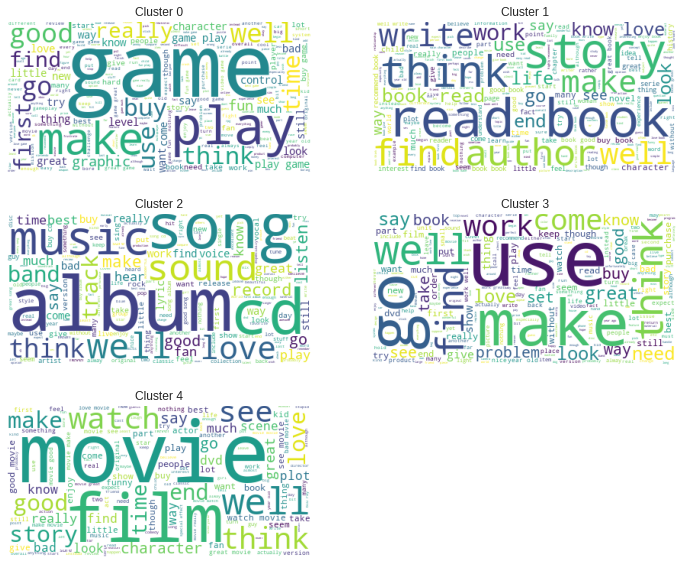

In [ ]:
# Show wordcloud for every cluster
fig = plt.figure(figsize=(12, 10))
for cluster in range(0, visualizer.elbow_value_):
  ax = fig.add_subplot(((visualizer.elbow_value_+1)/2), 2, cluster+1)
  plt.title('Cluster ' + str(cluster))
  # Get the reviews belonging to a specific cluster
  text = ' '.join(df['preprocessed'][df['cluster']==cluster].values)
  wordcloud = get_wordcloud(text)
  ax.imshow(wordcloud)
  ax.axis('off')

In [ ]:
# Show the most important terms for every cluster by selecting the largest coordinates for the clusters centroids
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

terms = tfidf_vect.get_feature_names_out()
for i in range(visualizer.elbow_value_):
    print("Cluster %d:" % i, end="")
    for ind in order_centroids[i, :10]:
        print(" %s" % terms[ind], end="")
    print()

Top terms per cluster:

Cluster 0: game play be fun but get graphic like not good
Cluster 1: book read be not but story write good like character
Cluster 2: album cd song be music like but listen sound good
Cluster 3: be not but use get work product good would buy
Cluster 4: movie be watch but see film not good like great
